In [1]:
import os
import random
import subprocess
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import Optional, Callable
import matplotlib.pyplot as plt
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import draw_segmentation_masks
from zipfile import ZipFile

In [5]:
_path_chest = "/home/data/02_SSD4TB/suzy/datasets/public/chest-xray"
_path_dsb = "/home/data/02_SSD4TB/suzy/datasets/public/data-science-bowl-2018"
_path_histo = "/home/data/02_SSD4TB/suzy/datasets/public/histopathologic-cancer-detection"
_path_ranzcr = "/home/data/02_SSD4TB/suzy/datasets/public/ranzcr-clip-catheter-line-classification"
_path_retina = "/home/data/02_SSD4TB/suzy/datasets/public/aptos2019-blindness-detection"

In [54]:
class DSB18Dataset(Dataset):
    r"""PyTorch friendly DSB18Dataset class

    Dataset is loaded using Kaggle API.
    For further information on raw dataset and nuclei segmentation, please refer to [1]_.

    Examples
    ----------
    >>> train_dataset = DSB18Dataset(_path, transform=None, download=False, show=True)

    .. image:: ../imgs/DSB18Dataset.png
        :width: 300

    References
    ---------------
    .. [1] https://www.kaggle.com/c/data-science-bowl-2018/overview
    """

    def __init__(self, root: str = ".", download: bool = False, mode: str = "train", shape: int = 512, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, show: bool = True):

        tag = "data-science-bowl-2018"
        modes = ["train", "val", "test"]
        assert mode in modes, "Available options for mode: train, val"
        
        if mode == "train" or mode == "val":
            stage = "stage1_train"
        else:
            stage = "stage1_test"
        
        self.mode = mode
        path = os.path.join(root, tag, stage)
        
        if download:
            download_datasets(tag, path=root)
            extract_zip(os.path.join(root, tag+".zip"),
                        os.path.join(root, tag))
            extract_zip(os.path.join(root, tag, stage + ".zip"), path)
        else:
            path = os.path.join(root, stage)

        self.path = path
        self.shape = shape
        
        if self.mode != "test":
            seed = 42
            train_list = os.listdir(self.path)
            train_list, valid_list = train_test_split(
                train_list,
                test_size=0.2,
                random_state=seed
            )

            if self.mode == "train":
                self.folders = train_list
            elif self.mode == "val":
                self.folders = valid_list
        else:
            self.folders = os.listdir(self.path)

        if transform is None:
            self.transform = self.default_transform()
        else:
            self.transform = transform

        if target_transform is None:
            self.target_transform = self.default_target_transform()
        else:
            self.target_transform = target_transform

        if show:
            self.visualize_batch()

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        
        image_folder = os.path.join(self.path, self.folders[idx], 'images/')
        fname = os.listdir(image_folder)[0]
        image_path = os.path.join(image_folder, fname)
        img = Image.open(image_path).convert('RGB')
        img = self.transform(img)
        
        if self.mode != "test":
            mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')        
            mask = self.get_mask(mask_folder)
            mask = self.target_transform(mask)
            sample = (img, mask, fname)
        else:
            sample = (img, fname)
        
        return sample

    def get_mask(self, mask_folder):
        mask = np.zeros((self.shape, self.shape, 1), dtype=bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (self.shape, self.shape))
            mask_ = np.expand_dims(mask_, axis=-1)
            mask = np.maximum(mask, mask_)

        return mask

    def default_transform(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((self.shape, self.shape))
        ])

        return transform

    def default_target_transform(self):
        target_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((self.shape, self.shape))
        ])

        return target_transform

    def visualize_batch(self):
        loader = DataLoader(self, shuffle=True, batch_size=4)
        
        if self.mode != "test":
            imgs, masks, fnames = next(iter(loader))
        else:
            imgs, fnames = next(iter(loader))

        batch_inputs = F.convert_image_dtype(imgs, dtype=torch.uint8)
        
        if self.mode != "test":
            batch_outputs = F.convert_image_dtype(masks, dtype=torch.bool)
            list_imgs = [
                draw_segmentation_masks(
                    img, masks=mask, alpha=0.6, colors=(102, 255, 178))
                for img, mask in zip(batch_inputs, batch_outputs)
            ]
        else:
            list_imgs = [imgs[i] for i in range(len(imgs))]
            
        self.show(list_imgs, fnames)

    @staticmethod
    def show(imgs, fnames):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.detach()
            img = F.to_pil_image(img)
            axs[0, i].imshow(np.asarray(img))
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            axs[0, i].set_title("..."+fnames[i][-10:-4])

b'data-science-bowl-2018.zip: Skipping, found more recently modified local copy (use --force to force download)\n'
Extracting all the train files now...
Done!
Extracting all the train files now...
Done!


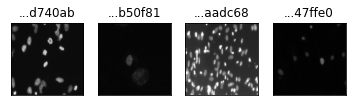

In [55]:
_path_dsb_download = "/home/data/02_SSD4TB/suzy/datasets/public/testy"
train_dataset = DSB18Dataset(_path_dsb_download, mode="test", download=True)

In [49]:
len(train_dataset)

65

In [ ]:
class DSB18Dataset(Dataset):
    r"""PyTorch friendly DSB18Dataset class

    Dataset is loaded using Kaggle API.
    For further information on raw dataset and nuclei segmentation, please refer to [1]_.

    Examples
    ----------
    >>> train_dataset = DSB18Dataset(_path, transform=None, download=False, show=True)

    .. image:: ../imgs/DSB18Dataset.png
        :width: 300

    References
    ---------------
    .. [1] https://www.kaggle.com/c/data-science-bowl-2018/overview
    """

    def __init__(self, root: str = ".", download: bool = False, mode: str = "train", shape: int = 512, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, show: bool = True):

        tag = "data-science-bowl-2018"
        modes = ["train", "val", "test"]
        assert mode in modes, "Available options for mode: train, val"
        
        if mode == "train" or mode == "val":
            stage = "stage1_train"
        else:
            stage = "stage1_test"
        
        self.mode = mode
        path = os.path.join(root, tag, stage)
        
        if download:
            download_datasets(tag, path=root)
            extract_zip(os.path.join(root, tag+".zip"),
                        os.path.join(root, tag))
            extract_zip(os.path.join(root, tag, stage + ".zip"), path)
        else:
            path = os.path.join(root, stage)

        self.path = path
        self.shape = shape
        train_list = os.listdir(self.path)
        train_list, valid_list = train_test_split(
            train_list,
            test_size=0.2,
            random_state=seed
        )
        
        if self.mode == "train":
            self.folders = train_list
        elif self.mode == "valid":
            self.folders = valid_list
        
        if transform is None:
            self.transform = self.default_transform()
        else:
            self.transform = transform

        if target_transform is None:
            self.target_transform = self.default_target_transform()
        else:
            self.target_transform = target_transform

        if show:
            self.visualize_batch()

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        
        image_folder = os.path.join(self.path, self.folders[idx], 'images/')
        fname = os.listdir(image_folder)[0]
        image_path = os.path.join(image_folder, fname)
        img = Image.open(image_path).convert('RGB')
        img = self.transform(img)
        
        if self.mode != "test":
            mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')        
            mask = self.get_mask(mask_folder)
            mask = self.target_transform(mask)
            sample = (img, mask, fname)
        else:
            sample = (img, fname)
        
        return sample

    def get_mask(self, mask_folder):
        mask = np.zeros((self.shape, self.shape, 1), dtype=bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (self.shape, self.shape))
            mask_ = np.expand_dims(mask_, axis=-1)
            mask = np.maximum(mask, mask_)

        return mask

    def default_transform(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((self.shape, self.shape))
        ])

        return transform

    def default_target_transform(self):
        target_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((self.shape, self.shape))
        ])

        return target_transform

    def visualize_batch(self):
        loader = DataLoader(self, shuffle=True, batch_size=4)
        
        if self.mode != "test":
            imgs, masks, fnames = next(iter(loader))
        else:
            imgs, fnames = next(iter(loader))

        batch_inputs = F.convert_image_dtype(imgs, dtype=torch.uint8)
        
        if self.mode != "test":
            batch_outputs = F.convert_image_dtype(masks, dtype=torch.bool)
            list_imgs = [
                draw_segmentation_masks(
                    img, masks=mask, alpha=0.6, colors=(102, 255, 178))
                for img, mask in zip(batch_inputs, batch_outputs)
            ]
        else:
            list_imgs = [imgs[i] for i in range(len(imgs))]
            
        self.show(list_imgs, fnames)

    @staticmethod
    def show(imgs, fnames):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.detach()
            img = F.to_pil_image(img)
            axs[0, i].imshow(np.asarray(img))
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            axs[0, i].set_title("..."+fnames[i][-10:-4])

In [27]:
train_dataset.shape

512

b'chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)\n'
Extracting all the train files now...
Done!


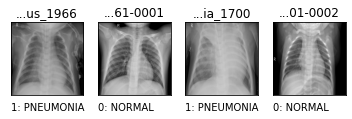

In [36]:
_path_chest_download = "/home/data/02_SSD4TB/suzy/datasets/public/testy"
train_dataset = ChestXrayDataset(_path_chest_download, mode="train", download=True)
#test_dataset = ChestXrayDataset(_path_chest_download, mode="test", download=True)
#val_dataset = ChestXrayDataset(_path_chest, mode="val", download=False)
#test_dataset = ChestXrayDataset(_path_chest, mode="test", download=False)

In [34]:
train_dataset

Dataset ChestXrayDataset
    Number of datapoints: 5216
    Root location: /home/data/02_SSD4TB/suzy/datasets/public/testy/chest-xray-pneumonia/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [30]:
test_dataset

Dataset ChestXrayDataset
    Number of datapoints: 624
    Root location: /home/data/02_SSD4TB/suzy/datasets/public/testy/chest-xray-pneumonia/chest_xray/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [11]:
val_dataset

Dataset ChestXrayDataset
    Number of datapoints: 16
    Root location: /home/data/02_SSD4TB/suzy/datasets/public/chest-xray/val
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [12]:
test_dataset

Dataset ChestXrayDataset
    Number of datapoints: 624
    Root location: /home/data/02_SSD4TB/suzy/datasets/public/chest-xray/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

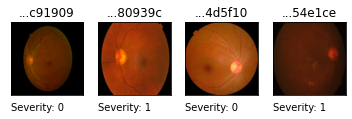

In [7]:
train_dataset = RetinopathyDataset(_path_retina, mode="train", show=True)

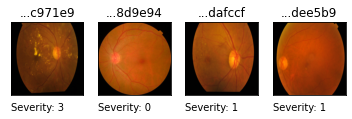

In [63]:

#train_dataset.visualize_dataset(9)

In [18]:
fnames

('50d8a8fb7737', '799214e8b07c', 'a73c3d516c59', '7ae69d22075a')

In [170]:
img,mask,fname=next(iter(train_dataset))

In [174]:
img[0].shape

torch.Size([512, 512])

In [145]:

                       
#         if labels[i] == 0:
#             lab = "non-tumor"
#         else:
#             lab = "tumor"
#         axs[0, i].text(0, -0.2, str(int(labels[i])) + ": " +
#                        lab, fontsize=12, transform=axs[0, i].transAxes)
#         axs[0, i].set_title("..."+fnames[i][-6:])

NameError: name 'self' is not defined

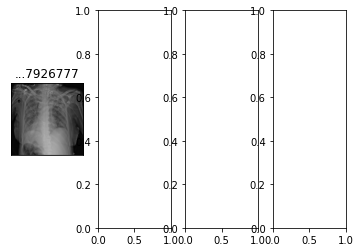

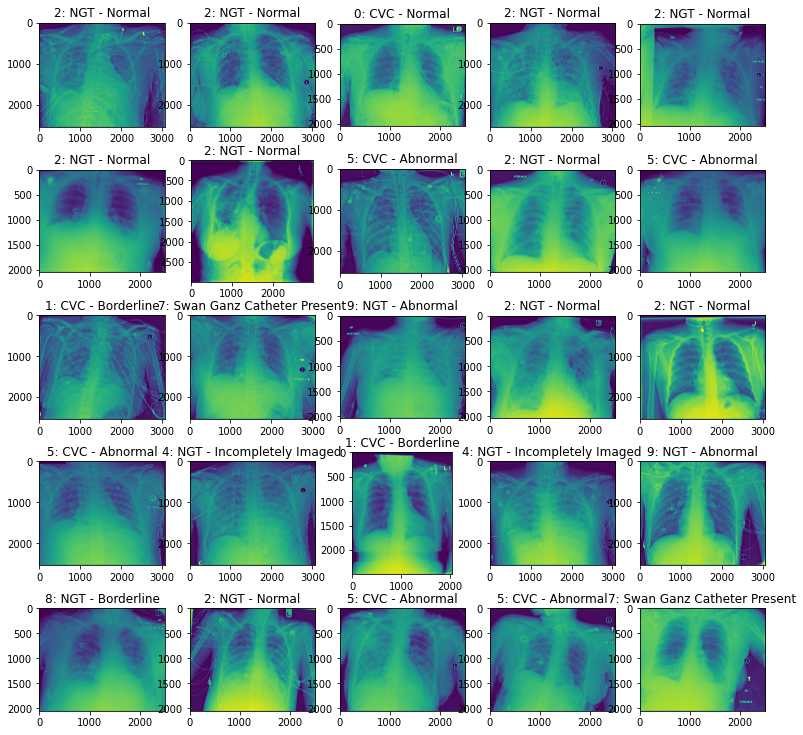

In [93]:
train_dataset.visualize_dataset()